## Predict Daily Minimum Temperatures pipeline

### Import libraries

In [242]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Reshape
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Concatenate, Activation, BatchNormalization, MaxPooling1D, Dropout, add, Bidirectional, Flatten, RepeatVector
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform

#AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

In [260]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Load and preprocessing the dataset 

In [261]:
filenames = sorted(glob.glob('Data/*'))
filenames[:5]

['Data/2000_2000_Jan_Mai.csv',
 'Data/2000_2000_Jun_Nov.csv',
 'Data/2000_2001_Dez_Mai.csv',
 'Data/2001_2001_Jun_Nov.csv',
 'Data/2001_2002_Dez_Mai.csv']

In [267]:
data = pd.DataFrame()
names=['Data','Hora (UTC)','Temp. Ins. (C)','Temp. Max. (C)','Temp. Min. (C)','Umi. Ins. (%)','Umi. Max. (%)','Umi. Min. (%)','Chuva (mm)']

for filename in filenames:
    try:
        df_aux = pd.read_csv(filename, usecols=names)
    except:
        df_aux = pd.read_csv(filename, usecols=names, sep=';')
        
    if(len(df) == 0):
        data_df = df_aux
    else:
        data_df = pd.concat([df, df_aux])
    
    del df_aux
        
print(data_df.shape)
data_df.tail()

(208968, 9)


,Data,Hora (UTC),Temp. Ins. (C),Temp. Max. (C),Temp. Min. (C),Umi. Ins. (%),Umi. Max. (%),Umi. Min. (%),Chuva (mm)
3307,18/05/2023,1900,"32,2","32,4","30,5","57,0","67,0","57,0","0,0"
3308,18/05/2023,2000,"30,8","32,5","30,7","63,0","63,0","55,0","0,0"
3309,18/05/2023,2100,"29,2","30,9","29,2","74,0","74,0","63,0","0,0"
3310,18/05/2023,2200,"28,9","29,4","28,8","73,0","75,0","70,0","0,0"
3311,18/05/2023,2300,"28,2","29,0","28,2","82,0","82,0","73,0","0,0"


### Preprocessing 

In [268]:
for col in df.columns[2:]:
    data_df[col] = data_df[col].astype(str).str.replace(',','.').astype(float)
data_df['Data']=pd.to_datetime(data_df['Data'])
data_df

,Data,Hora (UTC),Temp. Ins. (C),Temp. Max. (C),Temp. Min. (C),Umi. Ins. (%),Umi. Max. (%),Umi. Min. (%),Chuva (mm)
0,2000-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-01,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-01,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-01,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-01,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3307,2023-05-18,1900,32.2,32.4,30.5,57.0,67.0,57.0,0.0
3308,2023-05-18,2000,30.8,32.5,30.7,63.0,63.0,55.0,0.0
3309,2023-05-18,2100,29.2,30.9,29.2,74.0,74.0,63.0,0.0
3310,2023-05-18,2200,28.9,29.4,28.8,73.0,75.0,70.0,0.0


In [269]:
aux1=data_df.groupby(['Data'])['Temp. Ins. (C)','Umi. Ins. (%)','Chuva (mm)'].agg('mean')
aux2=data_df.groupby(['Data'])['Temp. Max. (C)','Umi. Max. (%)'].agg('max')
aux3=data_df.groupby(['Data'])['Temp. Min. (C)','Umi. Min. (%)'].agg('min')
data_df= pd.concat([aux1, aux2,aux3], axis=1).reset_index()
data_df

/tmp/ipykernel_637030/2876059681.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aux1=data_df.groupby(['Data'])['Temp. Ins. (C)','Umi. Ins. (%)','Chuva (mm)'].agg('mean')
/tmp/ipykernel_637030/2876059681.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aux2=data_df.groupby(['Data'])['Temp. Max. (C)','Umi. Max. (%)'].agg('max')
/tmp/ipykernel_637030/2876059681.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aux3=data_df.groupby(['Data'])['Temp. Min. (C)','Umi. Min. (%)'].agg('min')


,Data,Temp. Ins. (C),Umi. Ins. (%),Chuva (mm),Temp. Max. (C),Umi. Max. (%),Temp. Min. (C),Umi. Min. (%)
0,2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
8534,2023-12-01,27.686957,76.478261,0.113043,32.7,92.0,24.2,56.0
8535,2023-12-02,25.912500,87.541667,1.800000,30.8,98.0,22.8,64.0
8536,2023-12-03,24.570833,95.291667,2.908333,25.9,97.0,22.9,91.0
8537,2023-12-04,28.950000,74.208333,0.000000,33.8,94.0,25.5,50.0


In [270]:
data_df.isna().sum() 

Data                 0
Temp. Ins. (C)    1183
Umi. Ins. (%)     1185
Chuva (mm)        1186
Temp. Max. (C)    1198
Umi. Max. (%)     1201
Temp. Min. (C)    1198
Umi. Min. (%)     1201
dtype: int64

<AxesSubplot:xlabel='Data'>

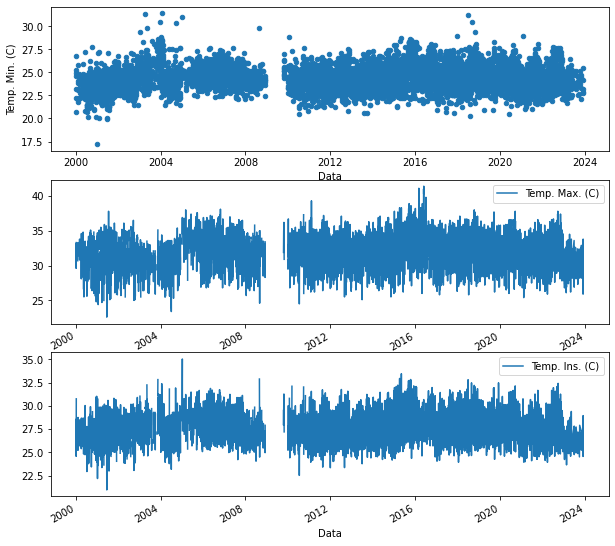

In [271]:
fig, axes = plt.subplots(3, 1, figsize=(10,10))

data_df.plot.scatter(x='Data',y='Temp. Min. (C)', ax= axes[0])
data_df.plot(x='Data',y='Temp. Max. (C)', ax= axes[1])
data_df.plot(x='Data',y='Temp. Ins. (C)', ax= axes[2])

In [305]:
new_data=data_df.ffill()[data_df['Data']>'2010-01-02']
new_data=new_data.ffill()
#new_data=new_data.bfill()
#new_data=new_data.interpolate()


<AxesSubplot:xlabel='Data'>

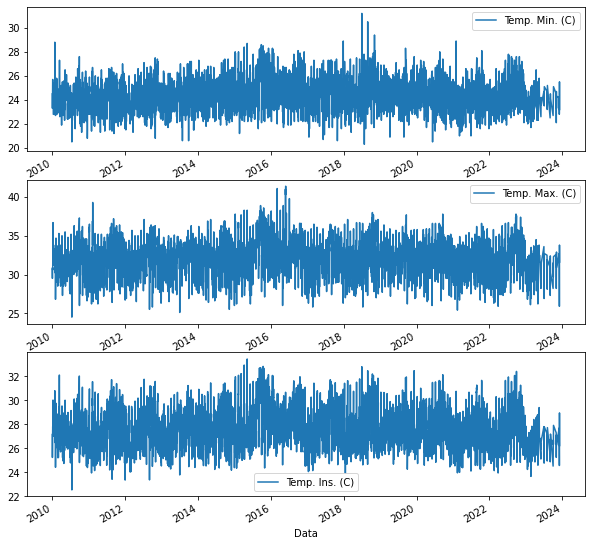

In [306]:
fig, axes = plt.subplots(3, 1, figsize=(10,10))

new_data.plot(x='Data',y='Temp. Min. (C)', ax= axes[0])
new_data.plot(x='Data',y='Temp. Max. (C)', ax= axes[1])
new_data.plot(x='Data',y='Temp. Ins. (C)', ax= axes[2])


In [307]:
new_data['week']=new_data['Data'].dt.week
new_data['weekday']=new_data['Data'].dt.weekday+1
new_data['day']=new_data['Data'].dt.day
new_data['month']=new_data['Data'].dt.month
new_data['quarter']=new_data['Data'].dt.quarter

/tmp/ipykernel_637030/2780441076.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  new_data['week']=new_data['Data'].dt.week


In [308]:
columns=new_data.columns[new_data.isna().sum().values <100]

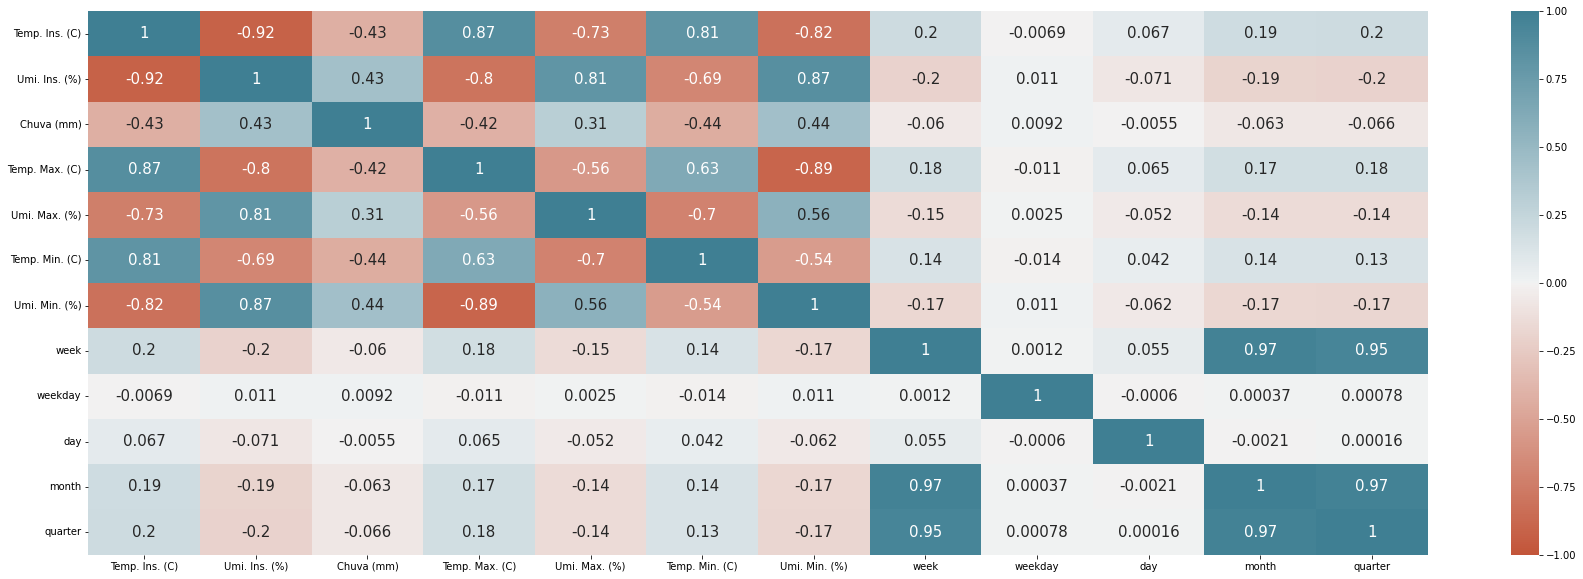

In [309]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(30,10))

corrmat = new_data[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [310]:
#sns.pairplot(data[columns])

### Init pipeline 

In [311]:
data= pd.DataFrame()
data['Date']=new_data['Data']
data['Temp']=new_data['Temp. Max. (C)']

In [312]:
data['Temp'].isna().sum()

0

In [313]:
Steps_ahead=180
windows_size=180

### Processing the data


In [314]:
data = data.set_index('Date')

real_temp=data[-Steps_ahead:]
data=data[0:-Steps_ahead]

#### Splitting data into train and vall sets

In [315]:
idx_train_vall=(len(data)//3)
idx_train=range(0,len(data)-idx_train_vall)
idX_vall=range(len(data)-idx_train_vall,len(data))

In [316]:
#idx_train, idX_vall = train_vall_split(np.arange(len(data)), vall_size=0.2, shuffle=False)

#idx_train

#train= data['Temp'][idx_train].values.reshape(-1, 1)
#vall= data['Temp'][idX_vall].values.reshape(-1, 1)

train=data.reset_index().iloc[idx_train,:]
train_norm= train.copy()
vall=data.reset_index().iloc[idX_vall,:]
vall_norm= vall.copy()
# scale the data - normalization
scaler = MinMaxScaler()
train_norm['Temp'] = scaler.fit_transform(train['Temp'].values.reshape(-1, 1))
vall_norm['Temp'] = scaler.transform(vall['Temp'].values.reshape(-1, 1))

#pd.DataFrame(data).describe()

In [317]:
# Creating the input and output data for the neural network
def create_dataset(windows_size, data, Date=None):
    X, Y = [], []
    t_date =[]
    for i in range(len(data)-windows_size):
        X.append(data[i:i+windows_size])
        Y.append(data[i+windows_size])
        if [Date] != None:
            t_date+=[Date[i+windows_size]]
    if [Date] != None:
        return np.expand_dims(np.vstack(X),2), np.array(Y), np.array(t_date)
    else: 
        return np.expand_dims(np.vstack(X),2), np.array(Y)

X_train, Y_train, t_train = create_dataset(windows_size ,train_norm['Temp'].values,train_norm['Date'].values)
X_vall, y_vall, t_vall = create_dataset(windows_size, vall_norm['Temp'].values,vall_norm['Date'].values)

In [318]:
vall_norm['Date']

3136   2018-08-05
3137   2018-08-06
3138   2018-08-07
3139   2018-08-08
3140   2018-08-09
          ...    
4699   2022-11-15
4700   2022-11-16
4701   2022-11-17
4702   2022-11-18
4703   2022-11-19
Name: Date, Length: 1568, dtype: datetime64[ns]

#### Plot the real temperature values

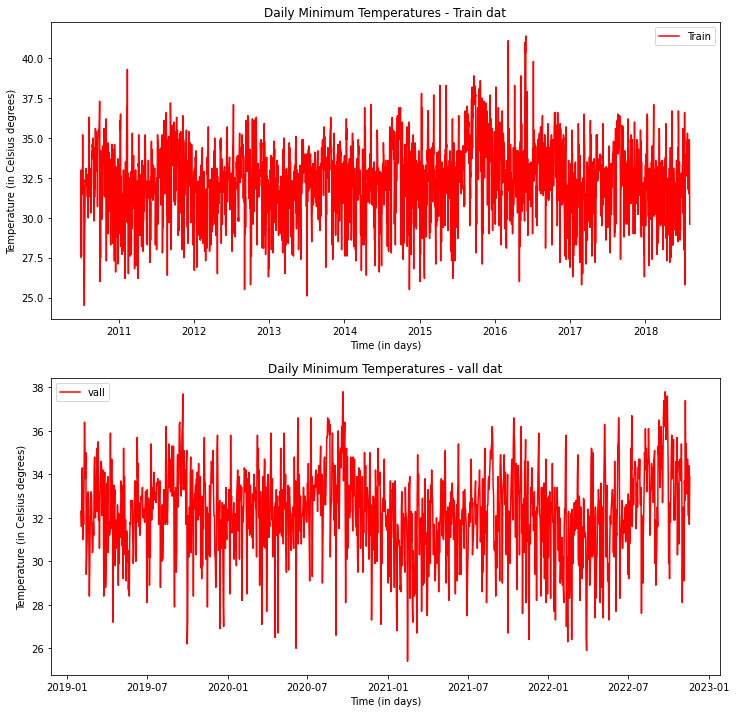

In [319]:

y_real_train= scaler.inverse_transform(Y_train.reshape(-1,1))
y_real_train_T = pd.to_datetime(t_train)

y_real_vall= scaler.inverse_transform(y_vall.reshape(-1,1))

y_real_vall_T = pd.to_datetime(t_vall)

fig=plt.figure(figsize=(12, 12))

ax1=plt.subplot(2,1,1)
plt.plot(y_real_train_T,y_real_train, color='red', label='Train')
ax1.set_title('Daily Minimum Temperatures - Train dat')
ax1.set_xlabel('Time (in days)')
ax1.set_ylabel('Temperature (in Celsius degrees)')
ax1.legend()

ax2=plt.subplot(2,1,2)
plt.plot(y_real_vall_T,y_real_vall, color='red', label='vall')
ax2.set_title('Daily Minimum Temperatures - vall dat')
ax2.set_xlabel('Time (in days)')
ax2.set_ylabel('Temperature (in Celsius degrees)')
ax2.legend()

plt.show()

### deep learning model 

In [320]:
# Set the random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [321]:
model_name= "MLP"

In [322]:
# Camada de entrada
input_data = Input(shape=(windows_size,))

dense_output = Dense(64, activation='relu')(input_data)
#dense_output=Dropout(0.5)(dense_output)

dense_output = Dense(64, activation='relu')(dense_output)
#dense_output=Dropout(0.5)(dense_output)

#dense_output = Dense(10, activation='relu')(dense_output)
#dense_output=Dropout(0.5)(dense_output)

# Camada de saída
output = Dense(1, activation='linear')(dense_output)


model = Model(inputs=input_data, outputs=output)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180)]             0         
                                                                 
 dense_22 (Dense)            (None, 64)                11584     
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 15,809
Trainable params: 15,809
Non-trainable params: 0
_________________________________________________________________


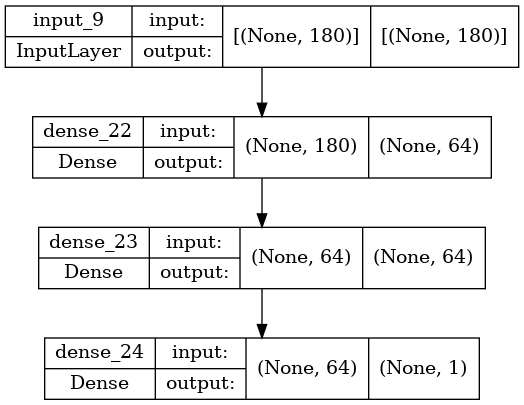

In [323]:
#plotting the model architechture
from tensorflow.keras.utils import plot_model
# Plot the model architecture
plot_model(model, show_shapes=True, show_layer_names=True)

#### Callbacks

In [324]:

EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=30, verbose=1, mode="min", restore_best_weights=True,)
checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}'

csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)

print("Training model :", checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 3, min_lr=1e-14,verbose=1)
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))


Training model : models/MLP


#### metrics

In [325]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

In [326]:
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
#optimizer1 = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
#optimizer1 = tf.keras.optimizers.RMSprop()

model.compile(loss=tf.keras.losses.mse, optimizer=optimizer1,metrics=[NRMSE])
history=model.fit( x=X_train, y=Y_train, shuffle=True, validation_data=(X_vall,y_vall), epochs=200, batch_size=255,callbacks=[EarlyStopping,model_checkpoint_callback,reduceLr])

Epoch 1/200
 1/12 [=>............................] - ETA: 2s - loss: 0.5098 - NRMSE: 0.2860
Epoch 1: val_loss improved from inf to 0.05527, saving model to models/MLP
INFO:tensorflow:Assets written to: models/MLP/assets
12/12 [==============================] - 1s 44ms/step - loss: 0.2396 - NRMSE: 0.6095 - val_loss: 0.0553 - val_NRMSE: 0.7602 - lr: 0.0100
Epoch 2/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0639 - NRMSE: 0.7472
Epoch 2: val_loss improved from 0.05527 to 0.02081, saving model to models/MLP
INFO:tensorflow:Assets written to: models/MLP/assets
12/12 [==============================] - 0s 35ms/step - loss: 0.0291 - NRMSE: 0.8336 - val_loss: 0.0208 - val_NRMSE: 0.8521 - lr: 0.0100
Epoch 3/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0256 - NRMSE: 0.8401
Epoch 3: val_loss improved from 0.02081 to 0.01695, saving model to models/MLP
INFO:tensorflow:Assets written to: models/MLP/assets
12/12 [==============================] - 0s 35ms/step - lo

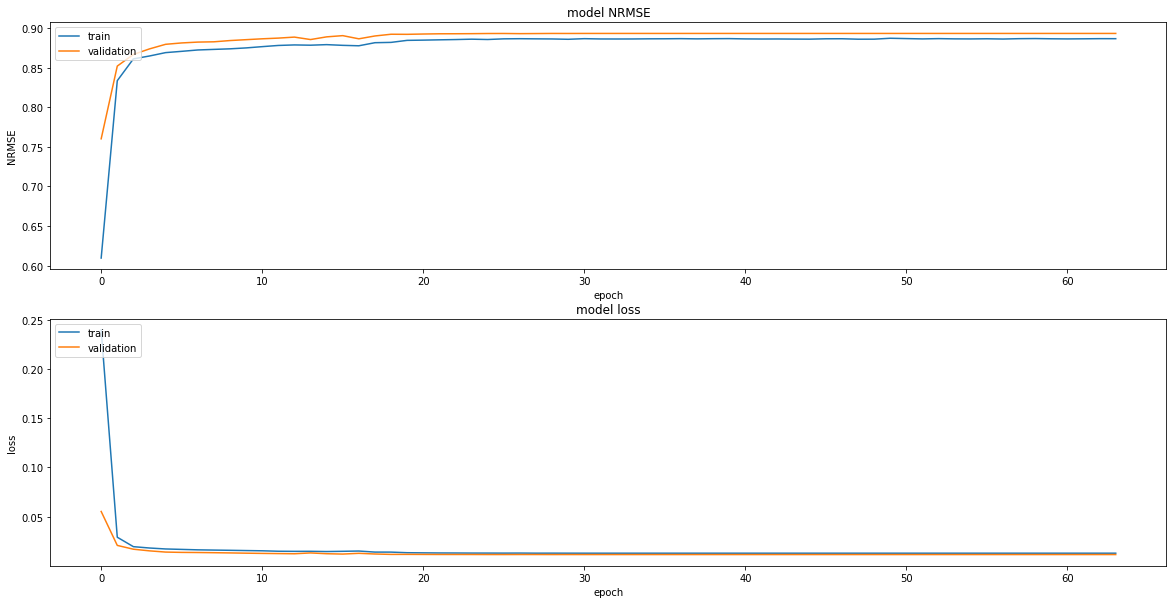

In [327]:
plt.figure(1,figsize=(20,10))  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['NRMSE']) 
plt.plot(history.history['val_NRMSE'])  
plt.title('model NRMSE')  
plt.ylabel('NRMSE')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left') 
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])   
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  

In [328]:
from tensorflow import keras
model=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [329]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )


y_pred=scaler.inverse_transform(model.predict(X_vall))
r2_score= R2(y_real_vall, y_pred )
print('NN R2:', r2_score)

NN R2: 0.20332960620912033


In [330]:
# Evaluate the stacked model
mse = mean_squared_error(y_real_vall,y_pred)
print('NN MSE:', mse)

NN MSE: 3.2855218929852392


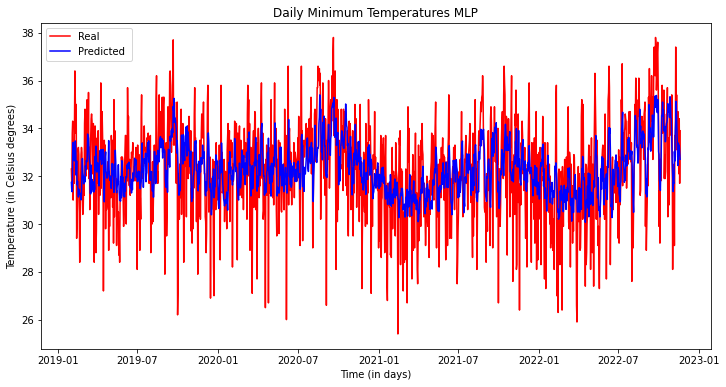

In [332]:
# Plot the real and predicted temperature values
plt.figure(figsize=(12, 6))
plt.plot(y_real_vall_T, y_real_vall, color='red', label='Real')
plt.plot(y_real_vall_T,y_pred, color='blue', label='Predicted ')
plt.title(f'Daily Minimum Temperatures {model_name}')
plt.xlabel('Time (in days)')
plt.ylabel('Temperature (in Celsius degrees)')
plt.legend()
plt.show()

### Xgboost

In [333]:
#%%
from xgboost import XGBRegressor

# Building the XGBoost model
xgb_model = XGBRegressor(n_estimators=10000, max_depth=3, learning_rate=0.1, subsample=1, colsample_bytree=0.8, objective='reg:squarederror',tree_method='gpu_hist', gpu_id=0, seed=42)
# Training the XGBoost model
xgb_model.fit(np.squeeze(X_train,2), Y_train)

# Make predictions on the valling dataset
xgb_preds =xgb_model.predict(np.squeeze(X_vall,2))

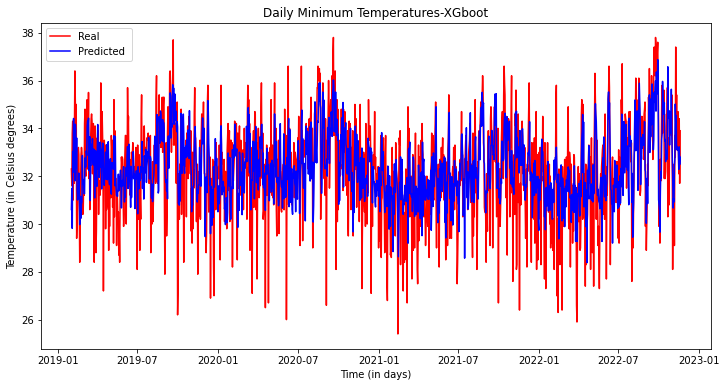

In [334]:
xgb_preds_scaler=scaler.inverse_transform(xgb_preds.reshape(-1,1))
# Plot the real and predicted temperature values
plt.figure(figsize=(12, 6))
plt.plot(y_real_vall_T, y_real_vall, color='red', label='Real')
plt.plot(y_real_vall_T,xgb_preds_scaler, color='blue', label='Predicted ')
plt.title('Daily Minimum Temperatures-XGboot')
plt.xlabel('Time (in days)')
plt.ylabel('Temperature (in Celsius degrees)')
plt.legend()
plt.show()

In [335]:
# Evaluate the stacked model
mse = mean_squared_error(y_real_vall,xgb_preds_scaler)
print('XGBoost MSE:', mse)

r2_score= R2(y_real_vall, xgb_preds_scaler )
print('XGBoost R2:', r2_score)

XGBoost MSE: 3.3974364466330353
XGBoost R2: 0.176192665890482


### Generating the predicted values for the next Steps  periods


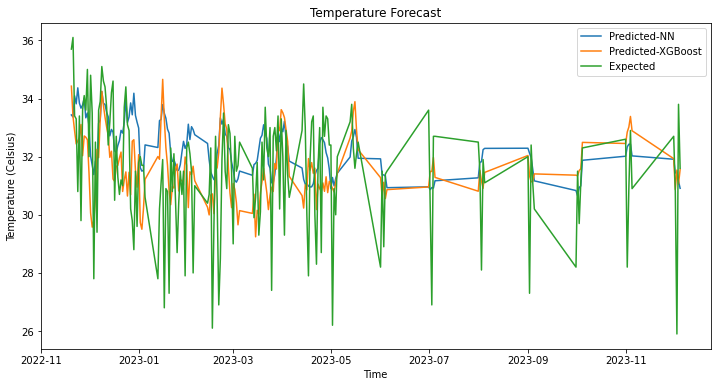

NN MSE: 4.509748022250865
XGBoost MSE: 4.437615986086822


In [336]:
last_window_NN = np.array(data.tail(windows_size)['Temp']).reshape(1, windows_size)[0]
last_window_xgb = last_window_NN.copy()

predicted_values_xgb = []
predicted_values_NN = []

windows=[] 
for i in range(Steps_ahead):
    ### NN 
    
    last_window_scaler_NN= scaler.transform(last_window_NN.reshape(-1,1))
    windows+=[last_window_scaler_NN]
    #last_window_scaler_NN=np.expand_dims(last_window_scaler_NN,axis=0)
    
    y_pred=model.predict(last_window_scaler_NN.reshape(1,-1,1))
    predicted_values_NN.append(scaler.inverse_transform(y_pred)[0][0])
    
    last_window_NN = np.append(last_window_NN[1:], predicted_values_NN[-1])
     
    ### XGB
    last_window_scaler_xgb= scaler.transform(last_window_xgb.reshape(-1,1))

    predicted_values_xgb.append(scaler.inverse_transform(xgb_model.predict(last_window_scaler_xgb.T)[0].reshape(-1,1))[0][0])

    last_window_xgb = np.append(last_window_xgb[1:], predicted_values_xgb[-1]).reshape(-1,1)
    
    
real_temp.index = pd.to_datetime(real_temp.index)
#predicted_values_NN= scaler.inverse_transform(np.array(predicted_values_NN).reshape(-1,1))
#predicted_values_xgb= scaler.inverse_transform(np.array(predicted_values_xgb).reshape(-1,1))


plt.figure(figsize=(12, 6))
plt.plot(real_temp.index, predicted_values_NN, label='Predicted-NN')
plt.plot(real_temp.index, predicted_values_xgb, label='Predicted-XGBoost')
plt.plot(real_temp.index, real_temp['Temp'], label='Expected')
plt.legend()
plt.title('Temperature Forecast')
plt.xlabel('Time')
plt.ylabel('Temperature (Celsius)')
plt.show()


# Evaluate the stacked model
mse = mean_squared_error(real_temp['Temp'], predicted_values_NN)
print('NN MSE:', mse)

# Evaluate the stacked model
mse = mean_squared_error(real_temp['Temp'], predicted_values_xgb)
print('XGBoost MSE:', mse)